# Workshop name

**Author:** Martin Beneš, Verena Lachner

<div style="text-align: center">
<img src="https://www.uibk.ac.at/media/filer_public/00/c3/00c369ba-9e7a-42a4-9f73-466c81dc951a/universitaet-innsbruck-logo-cmyk-farbe.jpg" style="height: 5em; display: inline; padding-right: 2em" />
<img src="https://www.uncoverproject.eu/wp-content/uploads/2021/05/UNCOVER-Logog-440x92.5-final-1.0.png" style="height: 4em; display: inline; padding-left: 2em" />
</div>

<div style="text-align: center">
<a href="https://www.github.com/uibk-uncover/mip-stego-demo">
github.com/uibk-uncover/mip-stego-demo
</a>
</div>

## Notebook setup

For this notebook, we will use a sample image `00001.tif` from ALASKA database. Run following code chunk to download it.

In [1]:
# download 00001.tif from ALASKA website
import requests
res = requests.get('http://alaska.utt.fr/DATASETS/ALASKA_v2_TIFF_512_COLOR/00001.tif', verify=False)
with open('00001.tif', 'wb') as f:
    f.write(res.content)
assert res.status_code == 200, res.text

/opt/miniconda3/envs/dev/lib/python3.8/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'alaska.utt.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.stats
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.set_printoptions(threshold=99)
plt.rcParams["figure.figsize"] = (12, 3)
np.random.seed(12345)  # for reproducibility
#
from matplotlib.pyplot import imshow, legend, ylim
from numpy import sum, histogram
from numpy.random import choice
from scipy.stats import chi2
from seaborn import histplot
#
im = Image.open('../img/girls.jpeg')  # load image
x = np.array(im.convert('L'))  # PIL to numpy

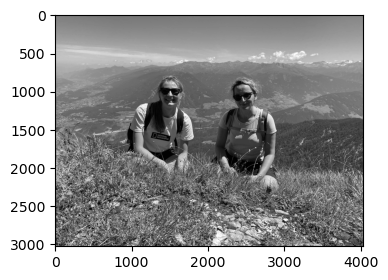

In [3]:
plt.imshow(x,cmap = "gray");

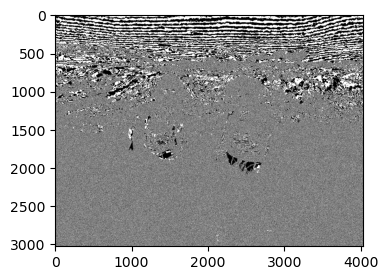

In [4]:
plt.imshow(x & 2,cmap = "gray");

In [5]:
def lsbr(x: np.ndarray, alpha: float = 1., method: str = 'permuted', seed: int = 12345) -> np.ndarray:
    """"""
    # probability
    if method == 'sequential':
        payload = int(np.ceil(alpha * x.size))
        probability = np.reshape([1/2.]*payload + [0]*(x.size - payload), x.shape)
    elif method == 'permuted':
        probability = np.ones(x.shape, dtype='float64') * alpha / 2
    else:
        raise NotImplementedError(f'unknown method {method}')
    # simulate
    rng = np.random.default_rng(seed)
    to_be_changed = rng.random(x.shape) < probability
    # modify
    y = np.copy(x)
    y[to_be_changed & (x % 2 == 0)] += 1
    y[to_be_changed & (x % 2 != 0)] -= 1
    return y

<center><h2>Let's play a coin game!</h2></center>

<center>
<img src="../img/coin.gif" width="320"/><br />
<tiny>Source: <a href="https://giphy.com/embed/FfrlRYkqKY1lC">https://giphy.com/</a></tiny>
</center>

$1000$ people toss a coin $100$ times, and count heads.

In [6]:
toss = choice([0, 1], size=[1000, 100])  # toss
toss_sums = sum(toss, axis=1)  # count heads

In [7]:
toss_sums

array([56, 50, 46, ..., 51, 44, 51])

For a fair coin, we expect the sum to be around $50$.

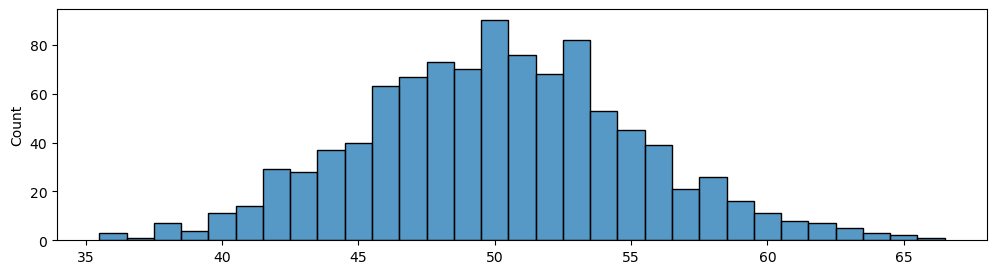

In [8]:
histplot(toss_sums, discrete=True);  # plot histogram

Histograms allows us to analyze data distribution graphically.

<center><h2>Playing with unfair coin</h2></center>

<center>
<img src="../img/trump.gif" width="320"/><br />
<tiny>Source: <a href="https://giphy.com/embed/KIejvpaS6QrAOdCLvu">https://giphy.com/</a></tiny>
</center>

We repeat the experiment with unfair coin.

Our unfair coin yields heads with a probability $52\%$.

In [9]:
toss2 = choice([0, 1], size=[1000, 100], p=[.48, .52])
toss2_sums = sum(toss2, axis=1)

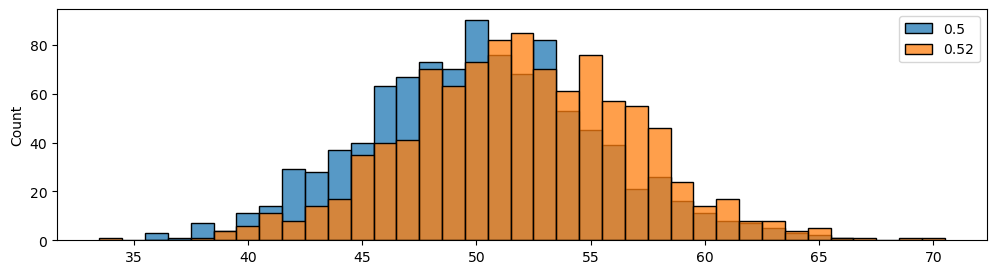

In [10]:
histplot(toss_sums, discrete=True, label='0.5');  # fair
histplot(toss2_sums, discrete=True, label='0.52');  # unfair
legend();

Is the orange histogram same as the blue one?

It is not an easy answer. 

We can test it using statistics.

$\chi^2$ test compares the shapes of two histograms, $h_1$ and $h_2$.

$$X^2=\sum_{i=1}^{N}\frac{(h_1 - h_2)^2}{h_1}$$

In [11]:
# histograms
h1 = histogram(toss_sums, range=(0, 100), bins=100)[0]
h2 = histogram(toss2_sums, range=(0, 100), bins=100)[0]

# test statistics
test_stat = 0
for i in range(100):
    if h1[i] > 0:
        test_stat += (h1[i] - h2[i])**2 / (h1[i])

In [12]:
test_stat  # test statistic

197.7241088701197

We convert the test statistic to p-value (using $\chi^2$ distribution).

In [13]:
chi2.sf(test_stat, 100-1)  # significant if <0.05

1.4826819136900469e-08

If the p-value is below $0.05$, the difference between the histograms is significant.

The histograms are different. **Something's wrong with the coin!**

<center><h2>Enough of coins, back to images!</h2></center>

<center>
<img src="../img/monalisa.gif" width="240"/><br />
<tiny>Source: <a href="https://giphy.com/embed/PmoyprrDzmpOVtFWJX">https://giphy.com/</a></tiny>
</center>

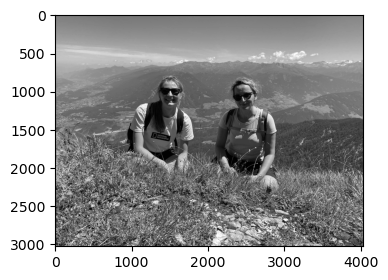

In [14]:
imshow(x,cmap = "gray");

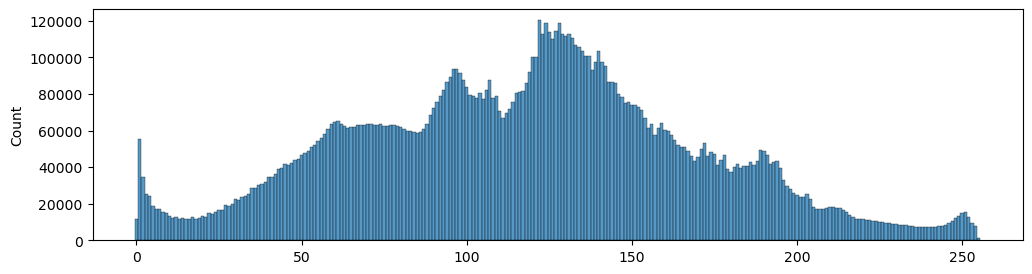

In [15]:
histplot(x.flatten(), discrete=True);  # cover histogram

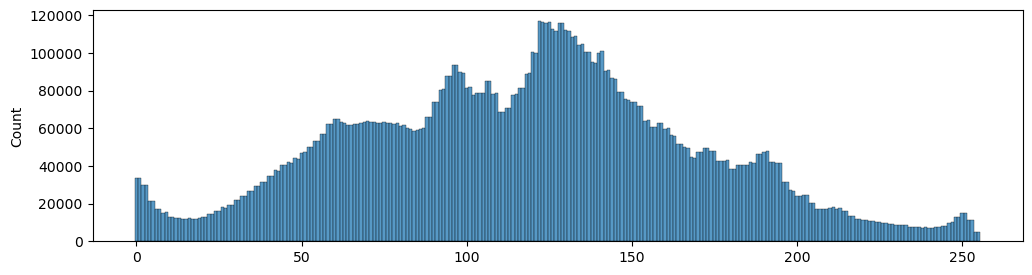

In [16]:
histplot(lsbr(x, 1.).flatten(), discrete=True);  # stego histogram

Let's take a closer look. What is going on with the histogram?

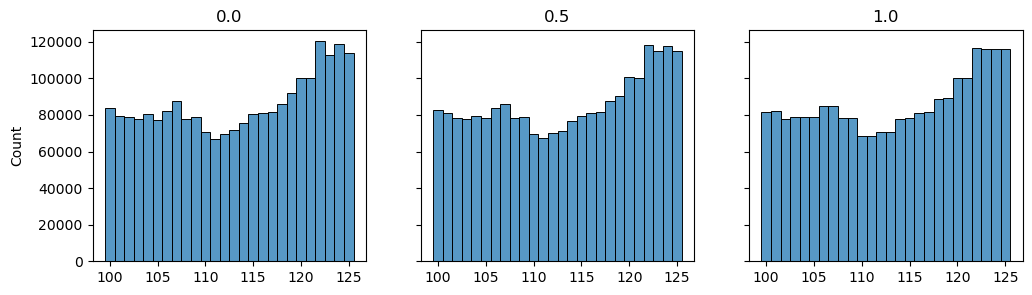

In [17]:
fig, ax = plt.subplots(1, 3, sharey=True)
for i, alpha in enumerate([.0, .5, 1.]):
    histplot(lsbr(x, alpha).flatten(), binrange=(100, 125), discrete=True, ax=ax[i]);
    ax[i].set_title(f'{alpha:.1f}');

LSBr averages the neighbor pairs (even and odd neighbor).

$$\bar{h}_i=\frac{h_{i}+h_{i+1}}{2}$$

In [42]:
# histogram
h = np.histogram(x.flatten(), bins=255, range=(0,255))[0]
# average even-odd pairs
hbar = (h[:-1:2] + h[1::2]) / 2

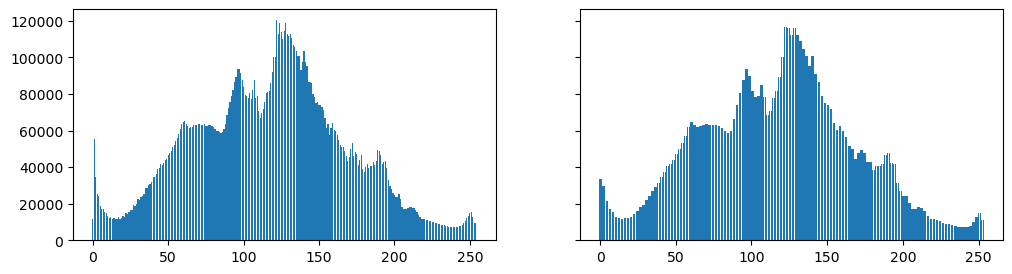

In [43]:
fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].bar(range(0,255), h);
ax[1].bar(range(0,254), np.repeat(hbar, 2));

Can we use $\chi^2$ test to detect steganography?

We can test the difference between the histogram, and its pair average.

If the histogram is similar to the pair-averaged histogram, steganography is present.

$$S=\sum_{i=0}^{254}\frac{(h_i-\bar{h}_i)^2}{\bar{h}_i}$$

In [20]:
# Chi2 test
test_stat = np.sum((h[:-1:2] - hbar)**2 / (hbar + 1e-18))
pvalue = chi2.sf(test_stat, h.size-1)

In [21]:
pvalue  # stego if >0.05

0.0

P-value is less than $5\%$, histograms are different. The image is **cover**.

We run the $\chi^2$-test for stego.

In [22]:
def chi2_attack(x):
    # histograms
    h = np.histogram(x.flatten(), bins=255, range=(0,255))[0]
    hbar = (h[:-1] + h[1:]) / 2
    # chi2 test
    S = np.sum((h[:-1:2] - hbar[::2])**2 / (hbar[::2] + 1e-18))
    return chi2.sf(S, h.size-1)

In [23]:
y = lsbr(x, 1.)  # create stego
pvalue = chi2_attack(y)  # chi2 attack

In [24]:
pvalue  # stego if >0.05

1.0

P-value is greater than $5\%$, histograms are the same. The image is **stego**.

## How good is our test?

How long messages can we detect?

In [25]:
pvalues = []
for alpha in np.arange(0, 1, .01):
    y = lsbr(x, alpha)  # create stego
    pvalue = chi2_attack(y)  # chi2 attack
    pvalues.append(pvalue)  # add to list

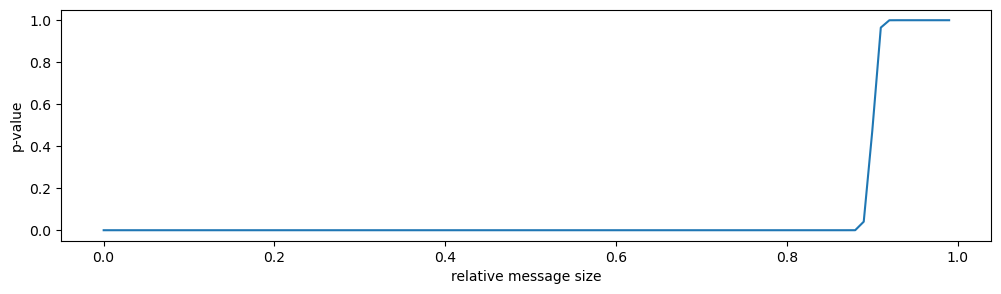

In [39]:
plt.plot(np.arange(0, 1, .01), pvalues);
plt.xlabel(r'relative message size'); plt.ylabel('p-value');

Meh.

<center><h2>Can we do better?</h2></center>

## LSBr leaves traces

LSBr leaves traces.

In [27]:
#
alpha = 1.
e = 2  # efficiency; because every other pixel is changed

In [28]:
#
payload = int(np.ceil(alpha * x.size))
probability = np.reshape([1/e]*payload + [0]*(x.size - payload), x.shape)
rng = np.random.default_rng(12345)
to_be_changed = rng.random(x.shape) < probability
print('Relative payload:', alpha)
print('Change rate:', np.mean(to_be_changed))

# modify
y = x.copy()
y[to_be_changed & (x % 2 == 0)] += 1
y[to_be_changed & (x % 2 != 0)] -= 1

Relative payload: 1.0
Change rate: 0.4999675217309146


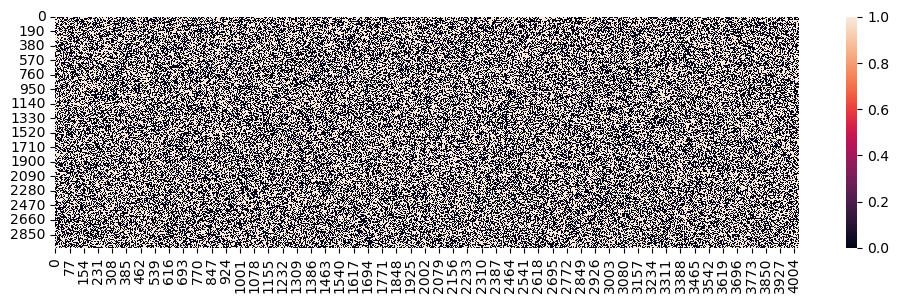

In [29]:
sns.heatmap(np.abs(y.astype('int') - x));

In [30]:
#
probability = np.ones(x.shape, dtype='float64') * alpha / e
rng = np.random.default_rng(12345)
to_be_changed = rng.random(x.shape) < probability
print('Relative payload:', alpha)
print('Change rate:', np.mean(to_be_changed))

# modify
y = x.copy()
y[to_be_changed & (x % 2 == 0)] += 1
y[to_be_changed & (x % 2 != 0)] -= 1

Relative payload: 1.0
Change rate: 0.4999675217309146


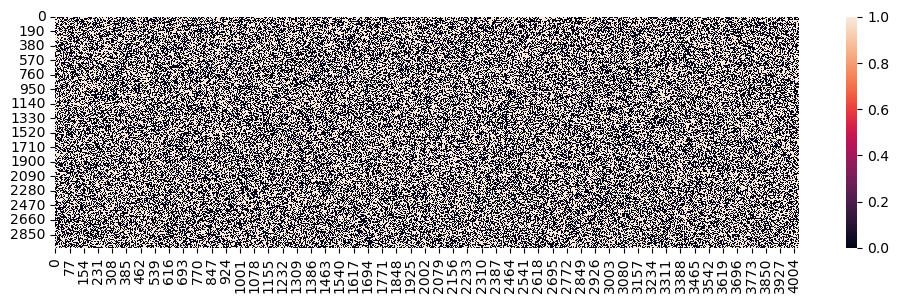

In [31]:
sns.heatmap(np.abs(y.astype('int') - x));

## We compare the histograms

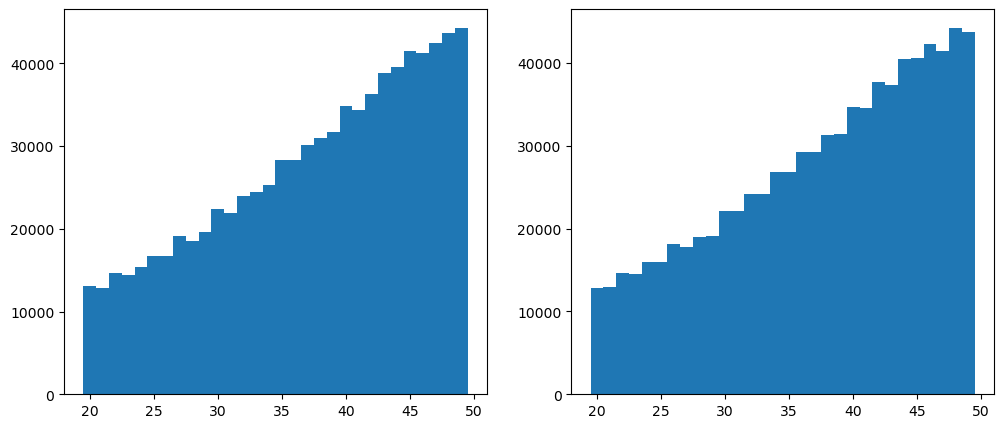

In [32]:
fig, ax = plt.subplots(1, 2, figsize = (12,5))
start, end = 20, 50
ax[0].hist(x.flatten(), bins=end-start, range=(start-.5, end-.5));
ax[1].hist(y.flatten(), bins=end-start, range=(start-.5, end-.5));